In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#changing directory

In [2]:
cd /content/drive/My\ Drive/Colab Notebooks/da/dap 

/content/drive/My Drive/Colab Notebooks/da/dap


In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle

In [4]:
"""
EGO_USER = 0 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f)
    
g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)
"""

"\nEGO_USER = 0 # which ego network to look at\n\n# Load pickled (adj, feat) tuple\nnetwork_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)\nwith open(network_dir, 'rb') as f:\n    adj, features = pickle.load(f)\n    \ng = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)\n"

2003
30991
30991
2003
<generator object connected_components at 0x7f8d0e7c6620>


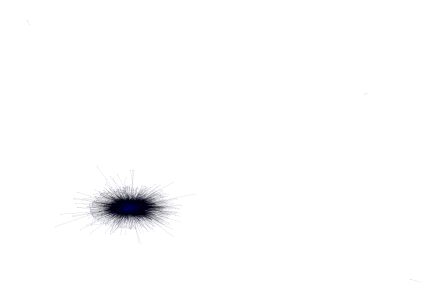

In [5]:
import numpy as np
import pandas as pd
def load_datax(path="data/"):
    """Load citation network dataset (cora only for now)"""
    #print('Loading {} dataset...'.format(dataset))

    idx_ = np.genfromtxt("{}{}.txt".format(path, "nodelist"),
                                        dtype=int)
    print(len(idx_))
    #features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    #labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    #idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    #idx_map = {j: i for i, j in enumerate(idx)}
    data = pd.read_csv('data/edgelist.txt', sep="(", header=None)
    col=data.columns
    data=data[col[1]]
    data = data.str.split(",",expand=True) 
    col=data.columns
    data1 = data[col[0]].str.split("{",expand=True) 
    data1=data1[data1.columns[1]]
    data2 = data[col[1]].str.split("}",expand=True)
    col=data2.columns
    #print(data1)
    data2=data2.drop(columns=col[1], axis = 1) 
    #print(data2)
    #data['new_col'] = list(zip(df.lat, df.long))
    data=pd.concat((data1,data2),axis=1)
    #data.rename(columns={data.columns[0]:'a',data.columns[1]:'b',data.columns[2]:'c'},inplace=True)
    #data = list(zip(data1, data2))
    #print(data)
    edge=[]
    for i in range(len(data.values)):
        
        edge.append((int(data.values[i][0]),int(data.values[i][1])))
    print(len(edge))
        
    G=nx.Graph()
    G.add_nodes_from(idx_)
    G.add_edges_from(edge)
    print(len(G.edges()))
    print(len(G.nodes()))
    print(nx.connected_components(G))
    options = {
    'node_color': 'blue',
    'node_size': 0.0005,
    'width':0.05,
    'arrowstyle': '-|>',
    'arrowsize': 1000,
    }
    nx.draw(G,arrows=True,**options)
    plt.savefig("graph.png", dpi=1000)
    plt.show()
    

    #print(data)

    adj=nx.adjacency_matrix(G)

    return adj,G
adj,G=load_datax()


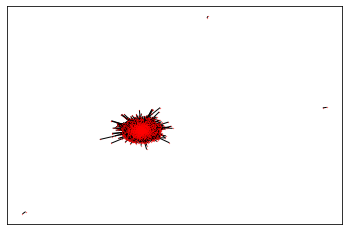

In [6]:
nx.draw_networkx(G, with_labels=False, node_size=0.05, node_color='r')
plt.show()

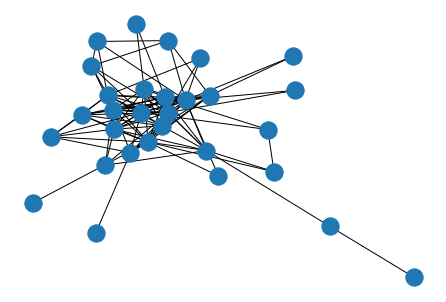

In [7]:
#new graph
import os
han=open("data/smalldawn.pickle","rb")
gx = pickle.load(han)
nx.draw(gx)

In [0]:
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_matrix(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")
    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print('creating false train edges...')

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false

# Perform train-test split
    # Takes in adjacency matrix in sparse format (from a directed graph)
    # Returns: adj_train, train_edges, val_edges, val_edges_false, 
        # test_edges, test_edges_false
def mask_test_edges_directed(adj, test_frac=.1, val_frac=.05, 
    prevent_disconnect=True, verbose=False, false_edge_sampling='iterative'):
    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    # Convert to networkx graph to calc num. weakly connected components
    g = nx.from_scipy_sparse_matrix(adj, create_using=nx.DiGraph())
    orig_num_wcc = nx.number_weakly_connected_components(g)

    adj_tuple = sparse_to_tuple(adj) # (coords, values, shape)
    edges = adj_tuple[0] # List of ALL edges (either direction)
    edge_pairs = [(edge[0], edge[1]) for edge in edges] # store edges as list of tuples (from_node, to_node)

    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be
    num_train = len(edge_pairs) - num_test - num_val # num train edges

    all_edge_set = set(edge_pairs)
    train_edges = set(edge_pairs) # init train_edges to have all edges
    test_edges = set() # init test_edges as empty set
    val_edges = set() # init val edges as empty set

    ### ---------- TRUE EDGES ---------- ###
    # Shuffle and iterate over all edges
    np.random.shuffle(edge_pairs)

    # get initial bridge edges
    bridge_edges = set(nx.bridges(nx.to_undirected(g))) 

    if verbose:
        print('creating true edges...')

    for ind, edge in enumerate(edge_pairs):
        node1, node2 = edge[0], edge[1]

        # Recalculate bridges every ____ iterations to relatively recent
        if ind % 10000 == 0:
            bridge_edges = set(nx.bridges(nx.to_undirected(g))) 

        # Don't sample bridge edges to increase likelihood of staying connected
        if (node1, node2) in bridge_edges or (node2, node1) in bridge_edges: 
            continue

        # If removing edge would disconnect the graph, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if not nx.is_weakly_connected(g):
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)
            if len(test_edges) % 10000 == 0 and verbose == True:
                print('Current num test edges: ', len(test_edges))

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)
            if len(val_edges) % 10000 == 0 and verbose == True:
                print('Current num val edges: ', len(val_edges))

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break



    # Check that enough test/val edges were found
    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")
    # Print stats for largest remaining WCC
    print('Num WCC: ', nx.number_weakly_connected_components(g))
    largest_wcc_set = max(nx.weakly_connected_components(g), key=len)
    largest_wcc = g.subgraph(largest_wcc_set)
    print('Largest WCC num nodes: ', largest_wcc.number_of_nodes())
    print('Largest WCC num edges: ', largest_wcc.number_of_edges())

    if prevent_disconnect == True:
        assert nx.number_weakly_connected_components(g) == orig_num_cc

    # Fraction of edges with both endpoints in largest WCC
    def frac_edges_in_wcc(edge_set):
        num_wcc_contained_edges = 0.0
        num_total_edges = 0.0
        for edge in edge_set:
            num_total_edges += 1
            if edge[0] in largest_wcc_set and edge[1] in largest_wcc_set:
                num_wcc_contained_edges += 1
        frac_in_wcc = num_wcc_contained_edges / num_total_edges
        return frac_in_wcc

    # Check what percentage of edges have both endpoints in largest WCC
    print('Fraction of train edges with both endpoints in L-WCC: ', frac_edges_in_wcc(train_edges))
    print('Fraction of test edges with both endpoints in L-WCC: ', frac_edges_in_wcc(test_edges))
    print('Fraction of val edges with both endpoints in L-WCC: ', frac_edges_in_wcc(val_edges))

    # Ignore edges with endpoint not in largest WCC
    print('Removing edges with either endpoint not in L-WCC from train-test split...')
    train_edges = {edge for edge in train_edges if edge[0] in largest_wcc_set and edge[1] in largest_wcc_set}
    test_edges = {edge for edge in test_edges if edge[0] in largest_wcc_set and edge[1] in largest_wcc_set}
    val_edges = {edge for edge in val_edges if edge[0] in largest_wcc_set and edge[1] in largest_wcc_set}


    ### ---------- FALSE EDGES ---------- ###

    # Initialize empty sets
    train_edges_false = set()
    test_edges_false = set()
    val_edges_false = set()

    # Generate candidate false edges (from g-complement) and iterate through them
    if false_edge_sampling == 'iterative':
        if verbose == True:
            print('preparing complement adjacency matrix...')

        # Sample false edges from G-complement, instead of randomly generating edges
        # g_complement = nx.complement(g)
        adj_complement = 1 - adj.toarray() # flip 0's, 1's in adjacency matrix
        np.fill_diagonal(adj_complement, val=0) # set diagonals to 0

        # 2 numpy arrays indicating x, y coords in adj_complement
            # WARNING: This line can use up a lot of RAM depending on 'adj' size
        idx1, idx2 = np.where(adj_complement == 1) 
            
        edges_false = np.stack((idx1, idx2), axis=-1) # stack arrays into coord pairs.
        edge_pairs_false = [(edge[0], edge[1]) for false_edge in edges_false]

        # Shuffle and iterate over false edges
        np.random.shuffle(edge_pairs_false)
        if verbose == True:
            print('adding candidate false edges to false edge sets...')
        for false_edge in edge_pairs_false:
            # Fill train_edges_false first
            if len(train_edges_false) < len(train_edges):
                train_edges_false.add(false_edge)
                if len(train_edges_false) % 100000 == 0 and verbose == True:
                    print('Current num false train edges: ', len(train_edges_false))

            # Fill test_edges_false next
            elif len(test_edges_false) < len(test_edges):
                test_edges_false.add(false_edge)
                if len(test_edges_false) % 100000 == 0 and verbose == True:
                    print('Current num false test edges: ', len(test_edges_false))

            # Fill val_edges_false last
            elif len(val_edges_false) < len(val_edges):
                val_edges_false.add(false_edge)
                if len(val_edges_false) % 100000 == 0 and verbose == True:
                    print('Current num false val edges: ', len(val_edges_false))

            # All sets filled --> break
            elif len(train_edges_false) == len(train_edges) and \
                len(test_edges_false) == len(test_edges) and \
                len(val_edges_false) == len(val_edges):
                break

    # Randomly generate false edges (idx_i, idx_j) 1 at a time to save memory
    elif false_edge_sampling == 'random':
        if verbose == True:
            print('creating false test edges...')

        # FALSE TEST EDGES
        while len(test_edges_false) < len(test_edges):
            idx_i = np.random.randint(0, adj.shape[0])
            idx_j = np.random.randint(0, adj.shape[0])
            if idx_i == idx_j: # no self-loops
                continue

            # Ensure both endpoints are in largest WCC
            if idx_i not in largest_wcc_set or idx_j not in largest_wcc_set:
                continue

            false_edge = (idx_i, idx_j)

            # Make sure false_edge not an actual edge, and not a repeat
            if false_edge in all_edge_set:
                continue
            if false_edge in test_edges_false:
                continue

            test_edges_false.add(false_edge)

            if len(test_edges_false) % 100000 == 0 and verbose == True:
                print ('Current num false test edges: ', len(test_edges_false))

        # FALSE VAL EDGES
        if verbose == True:
            print('creating false val edges...')

        while len(val_edges_false) < len(val_edges):
            idx_i = np.random.randint(0, adj.shape[0])
            idx_j = np.random.randint(0, adj.shape[0])
            if idx_i == idx_j:
                continue

            false_edge = (idx_i, idx_j)

            # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
            if false_edge in all_edge_set or \
                false_edge in test_edges_false or \
                false_edge in val_edges_false:
                continue
                
            val_edges_false.add(false_edge)

            if len(val_edges_false) % 100000 == 0 and verbose == True:
                print('Current num false val edges: ', len(val_edges_false))

        # FALSE TRAIN EDGES
        if verbose == True:
            print ('creating false train edges...')

        while len(train_edges_false) < len(train_edges):
            idx_i = np.random.randint(0, adj.shape[0])
            idx_j = np.random.randint(0, adj.shape[0])
            if idx_i == idx_j:
                continue

            false_edge = (idx_i, idx_j)

            # Make sure false_edge in not an actual edge, not in test_edges_false, 
                # not in val_edges_false, not a repeat
            if false_edge in all_edge_set or \
                false_edge in test_edges_false or \
                false_edge in val_edges_false or \
                false_edge in train_edges_false:
                continue

            train_edges_false.add(false_edge)

            if len(train_edges_false) % 100000 == 0 and verbose == True:
                print('Current num false train edges: ', len(train_edges_false))


    ### ---------- FINAL DISJOINTNESS CHECKS ---------- ###
    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_set)
    assert val_edges_false.isdisjoint(all_edge_set)
    assert train_edges_false.isdisjoint(all_edge_set)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('Num train edges (true, false): (', train_edges.shape[0], ', ', train_edges_false.shape[0], ')')
        print('Num test edges (true, false): (', test_edges.shape[0], ', ', test_edges_false.shape[0], ')')
        print('Num val edges (true, false): (', val_edges.shape[0], ', ', val_edges_false.shape[0], ')')
        print('')

    # Return final edge lists (edges can go either direction!)
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false

In [0]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape




In [0]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [0]:
#from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(gx)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.2, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [12]:
lna=list(gx.nodes())
lna

['METRONIDAZOLE',
 'ALFENTANIL',
 'FENTANYL',
 'KETAMINE',
 'AMINOPHYLLINE',
 'AMIODARONE',
 'GENTAMICIN',
 'LABETALOL',
 'CLONIDINE',
 'VANCOMYCIN',
 'ATRACURIUM',
 'DOBUTAMINE',
 'DOPAMINE',
 'ESMOLOL',
 'INSULIN',
 'MANNITOL',
 'MILRINONE',
 'MORPHINE',
 'OMEPRAZOLE',
 'THIOPENTAL',
 'VECURONIUM',
 'SODIUM',
 'MAGNESIUM',
 'MIDAZOLAM',
 'GLUCOSE',
 'POTASSIUM',
 'PROPOFOL',
 'HEPARIN',
 'ISOSORBIDE',
 'VASOPRESSIN']

#for plotting edges

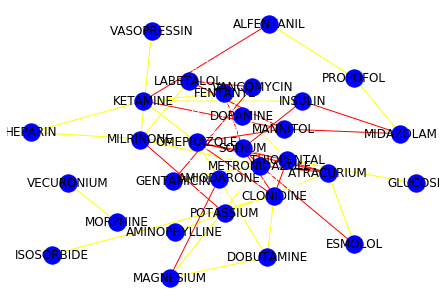

In [13]:
for e in gx.edges():
    gx[e[0]][e[1]]['color'] = 'grey'
    #print(e[0])
G = nx.Graph()
G.add_nodes_from(lna)
# Set color of edges of the shortest path to green
for i in range(len(train_edges)):
    G.add_edge(lna[int(train_edges[i][0])],lna[int(train_edges[i][1])])

    G[lna[int(train_edges[i][0])]][lna[int(train_edges[i][1])]]['color'] = 'white'
for i in range(len(val_edges)):
    G.add_edge(lna[int(val_edges[i][0])],lna[int(val_edges[i][1])])
    G[lna[int(val_edges[i][0])]][lna[int(val_edges[i][1])]]['color'] = 'white'
for i in range(len(val_edges_false)):
    G.add_edge(lna[int(val_edges_false[i][0])],lna[int(val_edges_false[i][1])])
    G[lna[int(val_edges_false[i][0])]][lna[int(val_edges_false[i][1])]]['color'] = 'white'
for i in range(len(test_edges)-1):
    G.add_edge(lna[int(test_edges[i][0])],lna[int(test_edges[i][1])])
    G[lna[int(test_edges[i][0])]][lna[int(test_edges[i][1])]]['color'] = 'red'
for i in range(len(test_edges_false)-1):
    G.add_edge(lna[int(test_edges_false[i][0])],lna[int(test_edges_false[i][1])])
    G[lna[int(test_edges_false[i][0])]][lna[int(test_edges_false[i][1])]]['color'] = 'yellow'
# Store in a list to use for drawing
edge_color_list = [G[e[0]][e[1]]['color'] for e in G.edges() ]
nx.draw(G, node_color='blue', edge_color = edge_color_list,   with_labels = True)
plt.savefig("graph1.png", dpi=1000)
plt.show()

In [14]:
# Inspect train/test split
print ("Total nodes:", adj_sparse.shape[0])
print ("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges)
print ("Training edges (positive):", len(train_edges))
print ("Training edges (negative):", len(train_edges_false))
print ("Validation edges (positive):", len(val_edges))
print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 30
Total edges: 111
Training edges (positive): 78
Training edges (negative): 78
Validation edges (positive): 11
Validation edges (negative): 11
Test edges (positive): 22
Test edges (negative): 22


In [0]:
import random


class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length, verbose=True):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		if verbose == True:
			print ('Walk iteration:')
		for walk_iter in range(num_walks):
			if verbose == True:
				print (str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return


def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [0]:
#import node2vec
from gensim.models import Word2Vec

In [0]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 2 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 50 # Length of walk per source
DIMENSIONS = 300 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 2 # Return hyperparameter
Q = 0.25 # In-out hyperparameter
WINDOW_SIZE = 2 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 50 # Length of walk per source
DIMENSIONS = 300 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [18]:
# Preprocessing, generate walks
g_n2v = Graph(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [list(map(str, walk)) for walk in walks]
print(walks)
# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
[['26', '2', '0', '4', '0', '14', '2', '5', '13', '5', '11', '21', '18', '14', '5', '10', '5', '2', '0', '4', '0', '1', '2', '18', '2', '27', '28', '27', '2', '7', '14', '5', '16', '5', '21', '17', '19', '14', '19', '5', '11', '5', '19', '21', '12', '7', '29', '9', '14', '2'], ['19', '0', '6', '5', '8', '5', '16', '20', '5', '14', '0', '4', '0', '12', '14', '5', '13', '5', '2', '7', '29', '9', '29', '7', '2', '0', '19', '10', '19', '5', '10', '9', '29', '9', '19', '21', '15', '8', '15', '12', '25', '20', '16', '19', '9', '14', '9', '12', '21', '26'], ['20', '5', '13', '5', '17', '21', '12', '25', '12', '19', '10', '23', '8', '6', '5', '6', '15', '21', '18', '12', '0', '19', '10', '5', '14', '0', '6', '22', '6', '22', '6', '22', '6', '0', '6', '8', '24', '8', '23', '0', '4', '0', '23', '10', '12', '26', '12', '26', '2', '0'], ['23', '8', '6', '8', '6', '0', '6', '15', '21', '19', '17', '21', '18', '5'

In [0]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [0]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        #print(emb2.shape)
        #edge_emb = np.multiply(emb1, emb2)
        edge_emb=np.concatenate([emb1,emb2])
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [0]:

# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [22]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:

# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

In [0]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [25]:
print ('node2vec Validation ROC score: ', str(val_roc))
print ('node2vec Validation AP score: ', str(val_ap))
print ('node2vec Test ROC score: ', str(test_roc))
print ('node2vec Test AP score: ', str(test_ap))

node2vec Validation ROC score:  0.6033057851239669
node2vec Validation AP score:  0.5415304689368861
node2vec Test ROC score:  0.5599173553719009
node2vec Test AP score:  0.5467801044463749


**
node2vec Validation ROC score:  0.9386929196054771

node2vec Validation AP score:  0.9377912696664061

node2vec Test ROC score:  0.9325099510079394

node2vec Test AP score:  0.9336681138266918

window=2**
####################################

**node2vec Validation ROC score:  0.9429004203648119

node2vec Validation AP score:  0.9415811583711047

node2vec Test ROC score:  0.9356062250769253

node2vec Test AP score:  0.9356915446784686

window=1**
